In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from fragment_count.views import plot_motif
from fragment_count.utils import entropy, pool, safe_normalise
from source import load_fragment_statistics

In [31]:
stats_per_response = load_fragment_statistics(statistic='fourmer')

In [33]:
resp_normal, resp_var = stats_per_response['responder (pr+cr)']
non_resp_normal, non_resp_var = stats_per_response['non responder (sd+pd)']
# Non-evaluables belong to the group of non-responders.
noneval_normal, noneval_var = stats_per_response['non evaluable (ne)']
non_resp_normal = non_resp_normal.append(noneval_normal)
non_resp_var = non_resp_var.append(noneval_var)

# Override `stats_per_response` to only include response and non-response.
del noneval_normal, noneval_var
stats_per_response['non responder (sd+pd)'] = (non_resp_normal, non_resp_var)
del stats_per_response['non evaluable (ne)']

In [34]:
resp_normal.sum(axis=1).groupby(['Patient ID', 'sample number']).sum().rename('count')

Patient ID  sample number
1023        0                49956
            1                29757
1031        0                 4257
            1                 5095
1032        0                49691
                             ...  
972         1                61929
979         0                31569
            1                22142
982         0                25834
            1                 4270
Name: count, Length: 90, dtype: int64

In [35]:
def count_4mer(data_frame):
    return data_frame.sum(axis=1).groupby(['Patient ID', 'sample number']).sum().rename('count')

print(count_4mer(resp_normal).mean(), '+/-', count_4mer(resp_normal).std())
print(count_4mer(resp_var).mean(), '+/-', count_4mer(resp_var).std())

25615.088888888888 +/- 27421.93414598279
1399.3 +/- 3683.2631460935277


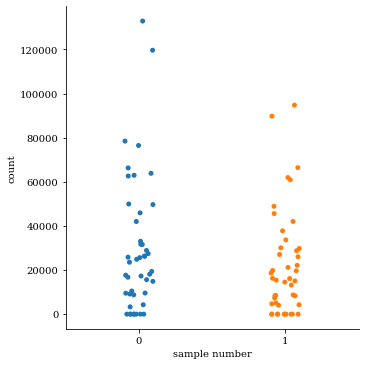

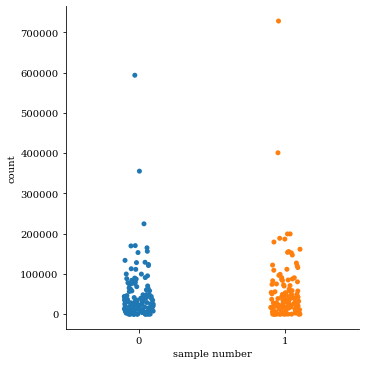

In [36]:
sns.catplot(
    data=resp_normal.sum(axis=1).groupby(['Patient ID', 'sample number']).sum().rename('count').reset_index(), 
    x='sample number', 
    y='count',
)

sns.catplot(
    data=non_resp_normal.sum(axis=1).groupby(['Patient ID', 'sample number']).sum().rename('count').reset_index(), 
    x='sample number', 
    y='count',
)

In [37]:
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']

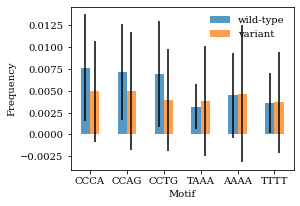

In [38]:
rn0 = resp_normal.loc[:, "0",:].sum(axis=1).groupby('Patient ID').apply(safe_normalise)
rv0 = resp_var.loc[:,"0",:].sum(axis=1).groupby('Patient ID').apply(safe_normalise)
plot_motif(
    motifs,
    rn0.groupby('4mer').mean(),
    rv0.groupby('4mer').mean(),
    rn0.groupby('4mer').std(),
    rv0.groupby('4mer').std(),
)

In [39]:
def normalise_per_patient(data_frame, time_point):
    return data_frame.loc[:, time_point, :].sum(axis=1) \
        .groupby('Patient ID') \
        .apply(safe_normalise)

def time_pair_plot(clinical_category, plot_i, motifs):
    normal, var = stats_per_response[clinical_category]
        
    p0_normal = normalise_per_patient(normal, time_point="0")
    p0_var = normalise_per_patient(var, time_point="0")
    
    p1_normal = normalise_per_patient(normal, time_point="1")
    p1_var = normalise_per_patient(var, time_point="1")

    # Responder, baseline.
    ax = plt.subplot(3, 2, plot_i)
    ax.set_title('Baseline')
    plot_motif(
        motifs, 
        p0_normal.groupby('4mer').mean(), 
        p0_var.groupby('4mer').mean(), 
        p0_normal.groupby('4mer').std(), 
        p0_var.groupby('4mer').std(),
        ax=ax,
    )
    ax.set_ylabel(clinical_category)
    ax.set_ylim([0.0, 0.013])

    # Responder, follow-up
    ax = plt.subplot(3, 2, plot_i + 1)
    ax.set_title('Follow-up')
    plot_motif(
        motifs, 
        p1_normal.groupby('4mer').mean(), 
        p1_var.groupby('4mer').mean(), 
        p1_normal.groupby('4mer').std(),
        p1_var.groupby('4mer').std(),
        ax=ax,
    )
    ax.set_ylim([0.0, 0.013])

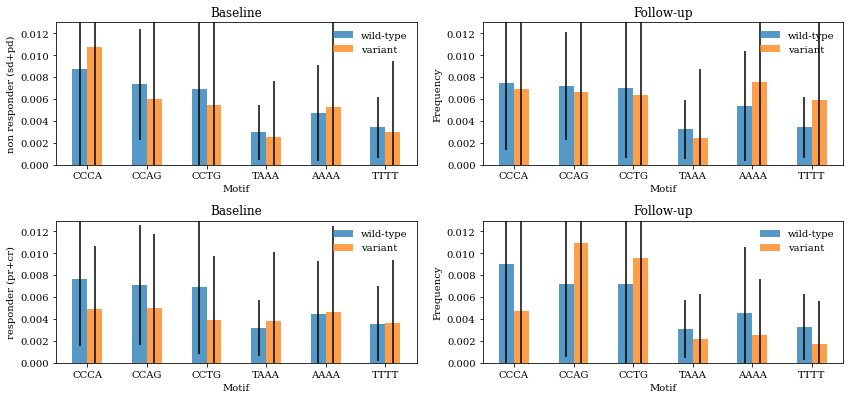

In [40]:
plt.figure(figsize=(12,8))

for i, response_category in enumerate(stats_per_response.keys()):
    time_pair_plot(response_category, 2*i + 1, motifs)

plt.tight_layout()
plt.savefig('figs/motifs.png')

# Entropy

In [42]:
def entropy_per_patient(data_frame, time_point, drop_zero=False):
    S = data_frame.loc[:, time_point, :].sum(axis=1) \
        .groupby('Patient ID') \
        .apply(safe_normalise) \
        .groupby('Patient ID') \
        .apply(entropy)
    if drop_zero:
        return S[S != 0.0]
    return S

[0.91270257 0.74145361 0.90395291 0.64158417]
[0.03943303 0.20129087 0.04368223 0.2190695 ]
[0.90487491 0.74065959 0.91070103 0.76442805]
[0.05263055 0.19232852 0.05301272 0.16719498]


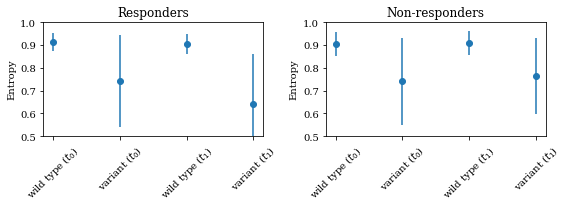

In [46]:
plt.figure(figsize=(8,3))

# Reponders
rn0 = entropy_per_patient(resp_normal, time_point="0", drop_zero=True)
rv0 = entropy_per_patient(resp_var, time_point="0", drop_zero=True)

rn1 = entropy_per_patient(resp_normal, time_point="1", drop_zero=True)
rv1 = entropy_per_patient(resp_var, time_point="1", drop_zero=True)

plt.subplot(1,2,1)
plt.title('Responders')
plt.rc('font', family='serif')
labels = ['wild type ($t_0$)', 'variant ($t_0$)', 'wild type ($t_1$)', 'variant ($t_1$)']
items = [rn0, rv0, rn1, rv1]

mean = np.array([i.mean() for i in items])
std = np.array([i.std() for i in items])
print(mean)
print(std)

plt.errorbar(x=labels, y=mean, yerr=std, fmt='o')
plt.ylabel('Entropy')
plt.ylim([0.5, 1])
plt.xticks(rotation=45)


# non-reponders
nrn0 = entropy_per_patient(non_resp_normal, time_point="0", drop_zero=True)
nrv0 = entropy_per_patient(non_resp_var, time_point="0", drop_zero=True)

nrn1 = entropy_per_patient(non_resp_normal, time_point="1", drop_zero=True)
nrv1 = entropy_per_patient(non_resp_var, time_point="1", drop_zero=True)

plt.subplot(1,2,2)
plt.title('Non-responders')
plt.rc('font', family='serif')
labels = ['wild type ($t_0$)', 'variant ($t_0$)', 'wild type ($t_1$)', 'variant ($t_1$)']
items = [nrn0, nrv0, nrn1, nrv1]

mean = np.array([i.mean() for i in items])
std = np.array([i.std() for i in items])
print(mean)
print(std)

plt.errorbar(x=labels, y=mean, yerr=std, fmt='o')
plt.ylabel('Entropy')
plt.ylim([0.5, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('figs/entropy_fourmer_response.png')